In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# 1 - Data import

In [3]:
cwr = os.getcwd().strip('/notebooks')
index = pd.read_csv(f'/{cwr}/raw_data/index.csv')
metadata = pd.read_csv(f'/{cwr}/raw_data/metadata.csv',index_col='class_id')
test = pd.read_csv(f'/{cwr}/raw_data/test.csv')
metadata.head()

,lego_ids,lego_names,minifigure_name
class_id,,,
1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,[76115],['Spider Mech vs. Venom'],VENOM
3,[76115],['Spider Mech vs. Venom'],AUNT MAY
4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
5,[75208],"[""Yoda's Hut""]",YODA


In [4]:
images = []
tests = []
for path in index['path']:
    image = np.asarray(Image.open(f'/{cwr}/raw_data/{path}')\
        .resize((224, 224))
        )
    images.append(image)
for path in test['path']:
    image = np.asarray(Image.open(f'/{cwr}/raw_data/{path}')\
        .resize((224, 224))
        )
    tests.append(image)
images = np.stack(images,axis=0)
tests = np.stack(tests,axis=0)
images.shape, tests.shape

((371, 224, 224, 3), (79, 224, 224, 3))

In [5]:
X_train = images
X_test = tests

In [6]:
y_train = np.array(index['class_id'])-1
y_test = np.array(test['class_id'])-1

# 2 - Data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = (0.8, 1.2),
    )

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [8]:
train_flow = train_datagen.flow(X_train, y_train, batch_size = 16)
valid_flow = test_datagen.flow(X_test, y_test, batch_size = 1)

# 3 - Best Transfer learning model

### Function to create the transfer learning so we can loop over it with different models

In [9]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.resnet import ResNet101,ResNet152,ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0,EfficientNetV2B1,EfficientNetV2B2,EfficientNetV2B3,EfficientNetV2L,EfficientNetV2M,EfficientNetV2S
from tensorflow.keras import layers, models as keras_models

def create_model(input_shape=(224,224,3),nb_labels=38,app=DenseNet201): #Function to create a transfer learning model, we can chose number of labels and the base model

    base_model = app(input_shape = input_shape,
                       include_top = False,
                       weights = 'imagenet',
                       classifier_activation='softmax')

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    # x = layers.Dense(224, activation = 'relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(nb_labels, activation = 'softmax')(x)

    return keras_models.Model(base_model.input,x)


### Let's loop

In [14]:
#Let's try many different models to see which one performs the best
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
list_models = [DenseNet201,ResNet101,ResNet152,ResNet50,VGG16,VGG19,EfficientNetV2B0,EfficientNetV2B1,EfficientNetV2B2,EfficientNetV2B3,EfficientNetV2L,EfficientNetV2M,EfficientNetV2S]
es = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               mode = 'max',
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=3,
                              min_lr=0.00001)
results = []
for m in list_models:
    model = create_model(app=m)
    model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy'])
    with tf.device('/GPU:0'):
        history = model.fit(
            train_flow,
            validation_data = valid_flow,
            epochs = 100,
            verbose=0,
            callbacks = [es,reduce_lr]
            )
        eval = model.evaluate(valid_flow, verbose=0)
        print(f'Accuracy of model {m} :     {eval[1]}')
        results.append(eval[1])


Accuracy of model <function DenseNet201 at 0x7f88a63eaf80> :     0.7848101258277893
Accuracy of model <function ResNet101 at 0x7f88a6216b00> :     0.2278480976819992
234698864/234698864 [==============================] - 52s 0us/step
Accuracy of model <function ResNet152 at 0x7f88a6216b90> :     0.13924050331115723
94765736/94765736 [==============================] - 21s 0us/step
Accuracy of model <function ResNet50 at 0x7f88a6216a70> :     0.18987341225147247


2023-12-12 10:00:55.085166: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-12 10:00:55.085217: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-12 10:00:55.085225: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-12 10:00:55.085230: W tensorflow/core/common_runtime/bfc_allocato

Accuracy of model <function VGG16 at 0x7f88a6217c70> :     0.746835470199585
Accuracy of model <function VGG19 at 0x7f88a6217eb0> :     0.6962025165557861
Accuracy of model <function EfficientNetV2B0 at 0x7f88a63ebd00> :     0.06329113990068436
28456008/28456008 [==============================] - 6s 0us/step
Accuracy of model <function EfficientNetV2B1 at 0x7f88a63ebd90> :     0.050632912665605545
35839040/35839040 [==============================] - 8s 0us/step
Accuracy of model <function EfficientNetV2B2 at 0x7f88a63ebe20> :     0.06329113990068436
52606240/52606240 [==============================] - 12s 0us/step
Accuracy of model <function EfficientNetV2B3 at 0x7f88a63ebeb0> :     0.06329113990068436
473176280/473176280 [==============================] - 104s 0us/step
Accuracy of model <function EfficientNetV2L at 0x7f88a62140d0> :     0.08860759437084198
214201816/214201816 [==============================] - 48s 0us/step
Accuracy of model <function EfficientNetV2M at 0x7f88a6214040>

In [35]:
for i,m in enumerate(["DenseNet201","ResNet101","ResNet152","ResNet50","VGG16","VGG19","EfficientNetV2B0","EfficientNetV2B1","EfficientNetV2B2","EfficientNetV2B3","EfficientNetV2L","EfficientNetV2M","EfficientNetV2S"]):
    print(f'Accuracy of model {m} : {results[i]}')

Accuracy of model DenseNet201 : 0.7848101258277893
Accuracy of model ResNet101 : 0.2278480976819992
Accuracy of model ResNet152 : 0.13924050331115723
Accuracy of model ResNet50 : 0.18987341225147247
Accuracy of model VGG16 : 0.746835470199585
Accuracy of model VGG19 : 0.6962025165557861
Accuracy of model EfficientNetV2B0 : 0.06329113990068436
Accuracy of model EfficientNetV2B1 : 0.050632912665605545
Accuracy of model EfficientNetV2B2 : 0.06329113990068436
Accuracy of model EfficientNetV2B3 : 0.06329113990068436
Accuracy of model EfficientNetV2L : 0.08860759437084198
Accuracy of model EfficientNetV2M : 0.050632912665605545
Accuracy of model EfficientNetV2S : 0.08860759437084198


#### The bests candidats are DenseNet201 and VGG16, we'll keep DensNet201 since it has the highest accuracy

# Without data augment

In [36]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model = create_model()
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               mode = 'max',
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=3,
                              min_lr=0.00001)
with tf.device('/GPU:0'):
    history = model.fit(
        X_train/255,
        y_train,
        validation_data = (X_test/255,y_test),
        epochs = 100,
        verbose=2,
        callbacks = [es,reduce_lr]
        )

Epoch 1/100
12/12 - 15s - loss: 19.1482 - accuracy: 0.1348 - val_loss: 12.7337 - val_accuracy: 0.1899 - lr: 0.0010 - 15s/epoch - 1s/step
Epoch 2/100
12/12 - 2s - loss: 2.8992 - accuracy: 0.7547 - val_loss: 5.6891 - val_accuracy: 0.5696 - lr: 0.0010 - 2s/epoch - 153ms/step
Epoch 3/100
12/12 - 1s - loss: 0.3812 - accuracy: 0.9488 - val_loss: 4.9782 - val_accuracy: 0.5190 - lr: 0.0010 - 1s/epoch - 121ms/step
Epoch 4/100
12/12 - 2s - loss: 0.1089 - accuracy: 0.9704 - val_loss: 5.8504 - val_accuracy: 0.4557 - lr: 0.0010 - 2s/epoch - 126ms/step
Epoch 5/100
12/12 - 2s - loss: 0.0105 - accuracy: 0.9946 - val_loss: 4.7599 - val_accuracy: 0.6076 - lr: 0.0010 - 2s/epoch - 152ms/step
Epoch 6/100
12/12 - 2s - loss: 0.0023 - accuracy: 0.9973 - val_loss: 5.2190 - val_accuracy: 0.6203 - lr: 0.0010 - 2s/epoch - 149ms/step
Epoch 7/100
12/12 - 2s - loss: 0.0055 - accuracy: 0.9973 - val_loss: 5.3060 - val_accuracy: 0.6203 - lr: 0.0010 - 2s/epoch - 129ms/step
Epoch 8/100
12/12 - 1s - loss: 2.1071e-04 - acc

In [37]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    # ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    # ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

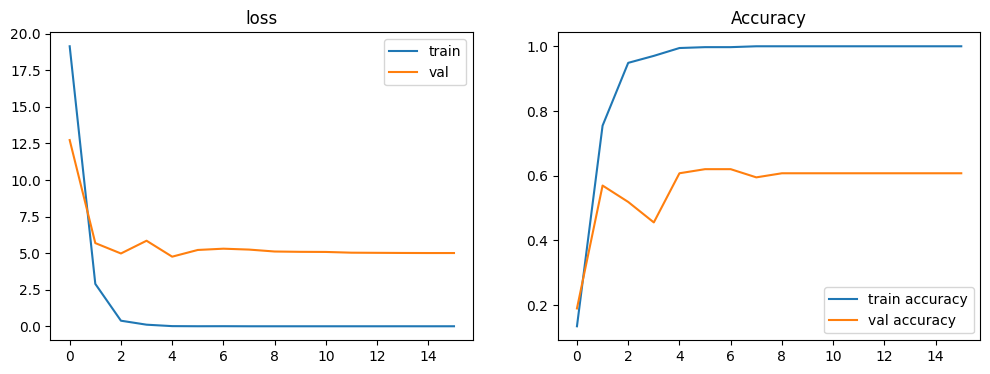

In [38]:
plot_history(history, title='Without data augmentation', axs=None, exp_name="")

In [39]:
model.evaluate(valid_flow)

79/79 [==============================] - 8s 65ms/step - loss: 5.2189 - accuracy: 0.6203


[5.218883037567139, 0.6202531456947327]

# With data Augment

In [43]:
model = create_model()
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               mode = 'max',
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=3,
                              min_lr=0.00001)
with tf.device('/GPU:0'):
    history = model.fit(
        train_flow,
        validation_data = valid_flow,
        epochs = 100,
        verbose=2,
        callbacks = [es,reduce_lr]
        )

Epoch 1/100
24/24 - 19s - loss: 15.9615 - accuracy: 0.2183 - val_loss: 7.1072 - val_accuracy: 0.4177 - lr: 0.0010 - 19s/epoch - 807ms/step
Epoch 2/100
24/24 - 8s - loss: 2.7298 - accuracy: 0.7089 - val_loss: 3.4398 - val_accuracy: 0.6582 - lr: 0.0010 - 8s/epoch - 322ms/step
Epoch 3/100
24/24 - 8s - loss: 0.8982 - accuracy: 0.8949 - val_loss: 5.3624 - val_accuracy: 0.5823 - lr: 0.0010 - 8s/epoch - 314ms/step
Epoch 4/100
24/24 - 7s - loss: 0.8592 - accuracy: 0.8895 - val_loss: 4.0418 - val_accuracy: 0.6076 - lr: 0.0010 - 7s/epoch - 307ms/step
Epoch 5/100
24/24 - 8s - loss: 0.7743 - accuracy: 0.8922 - val_loss: 4.6054 - val_accuracy: 0.6709 - lr: 0.0010 - 8s/epoch - 321ms/step
Epoch 6/100
24/24 - 8s - loss: 0.5109 - accuracy: 0.9353 - val_loss: 4.1439 - val_accuracy: 0.6962 - lr: 0.0010 - 8s/epoch - 323ms/step
Epoch 7/100
24/24 - 7s - loss: 0.5183 - accuracy: 0.9272 - val_loss: 4.7268 - val_accuracy: 0.5190 - lr: 0.0010 - 7s/epoch - 309ms/step
Epoch 8/100
24/24 - 7s - loss: 0.6188 - accur

In [46]:
model.evaluate(valid_flow)

79/79 [==============================] - 5s 64ms/step - loss: 2.4697 - accuracy: 0.7848


[2.4697375297546387, 0.7848101258277893]

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

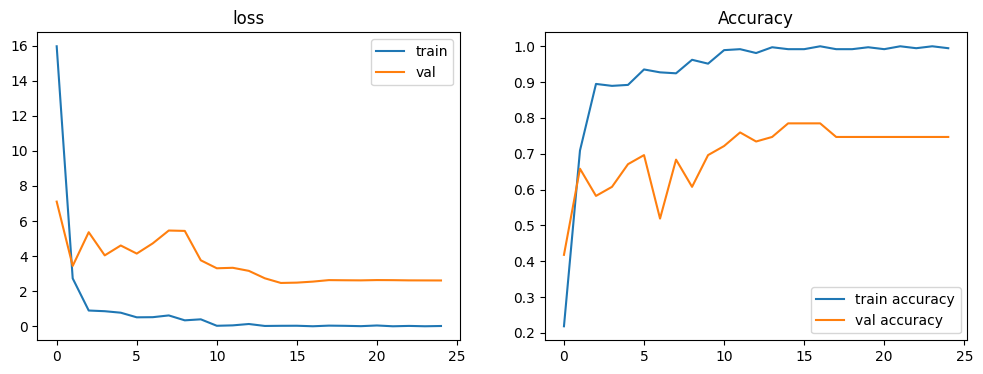

In [47]:
plot_history(history, title='With data augmentation', axs=None, exp_name="")

### Without any surprise, Data augmentation is clearly a winner here. It increases our accuracy by around 20%